# Epicurious Data Analysis

**Autor:** Raphael Brito Alencar

**Descrição:** Análise dos dados coletados do site https://www.epicurious.com/

In [601]:
# carregando libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, norm, probplot
import json
import gc

%matplotlib inline

In [602]:
# carregando dados de receitas.json
# verificando os primeiros registros
data = pd.read_json('receitas.json')
data.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


In [603]:
# informações sobre as colunas do dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
directions     20111 non-null object
fat            15908 non-null float64
date           20111 non-null datetime64[ns, UTC]
categories     20111 non-null object
calories       15976 non-null float64
desc           13495 non-null object
protein        15929 non-null float64
rating         20100 non-null float64
title          20111 non-null object
ingredients    20111 non-null object
sodium         15974 non-null float64
dtypes: datetime64[ns, UTC](1), float64(5), object(5)
memory usage: 1.7+ MB


In [604]:
# descrevendo estatísticas dos valores numéricos
# resultado sem dados tratados
data.describe().round(decimals=2)

,fat,calories,protein,rating,sodium
count,15908.00,15976.00,15929.00,20100.00,15974.00
mean,346.10,6307.86,99.95,3.71,6211.47
std,20431.02,358585.12,3835.62,1.34,332890.25
min,0.00,0.00,0.00,0.00,0.00
25%,7.00,198.00,3.00,3.75,80.00
50%,17.00,331.00,8.00,4.38,294.00
75%,33.00,586.00,27.00,4.38,711.00
max,1722763.00,30111218.00,236489.00,5.00,27675110.00


In [605]:
# percentual de preenchimento de cada feature
def show_filling_factor(data):
    missing_df = data.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['variable', 'missing values']
    missing_df['filling factor (%)'] = ((data.shape[0] - missing_df['missing values']) / data.shape[0]) * 100
    return missing_df.sort_values('filling factor (%)').reset_index(drop = True)

show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,6635,67.039245
1,fat,4222,79.026329
2,protein,4201,79.130651
3,sodium,4156,79.354198
4,calories,4154,79.364133
5,rating,30,99.850969
6,directions,19,99.905614
7,date,19,99.905614
8,categories,19,99.905614
9,title,19,99.905614


Olhando a tabela acima, parece que os registros nulos são os mesmos para categories, date, directions, ingredients e title. No caso, 19 registros. Verificando:

In [606]:
# tratando valores nulos
data[data['categories'].isna()]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
1076,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5146,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5424,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5558,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7607,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7768,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7881,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8177,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [607]:
# excluindo registros totalmente nulos
data.drop(data[data['categories'].isna()].index, inplace=True)

show_filling_factor(data)

,variable,missing values,filling factor (%)
0,desc,6616,67.102581
1,fat,4203,79.100990
2,protein,4182,79.205410
3,sodium,4137,79.429168
4,calories,4135,79.439113
5,rating,11,99.945304
6,directions,0,100.000000
7,date,0,100.000000
8,categories,0,100.000000
9,title,0,100.000000


Ao que parece, quando o valor de sodium não está preenchido, o valor de calories também não é preenchido. Apenas em dois casos que isso não acontece:

In [608]:
not_null_calories = data[data['calories'].notnull()]
not_null_calories[not_null_calories['sodium'].isna()]

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
687,"[Preheat oven to 350° F., In a baking pan toas...",0.0,2004-08-20 04:00:00+00:00,"[Hazelnut, Gourmet]",4.0,None,0.0,3.75,To Toast and Skin Hazelnuts,[Hazelnuts],NaN
17833,"[Preheat oven to 350° F., In a baking pan toas...",0.0,2004-08-20 04:00:00+00:00,"[Hazelnut, Gourmet]",4.0,None,0.0,3.75,To Toast and Skin Hazelnuts,[Hazelnuts],NaN


In [609]:
# preenchendo os dois valores com a mediana dos valores de sodio onde o valor de calorias é 4.0
q = 'calories == 4.0'
data.query(q)['sodium'].median()
data.loc[not_null_calories[not_null_calories['sodium'].isna()].index, 'sodium'] = data.query(q)['sodium'].median()

In [610]:
data.loc[not_null_calories[not_null_calories['sodium'].isna()].index, 'sodium']

687      210.0
17833    210.0
Name: sodium, dtype: float64

In [611]:
# verificando valores faltantes em rating
data['rating'].describe()

count    20100.000000
mean         3.713060
std          1.343144
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [612]:
# preenchendo os valores faltantes de rating com a média 
data.loc[data[data['rating'].isna()].index, 'rating'] = data['rating'].mean()

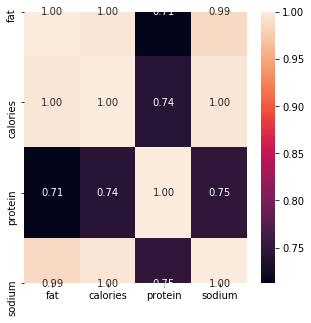

In [613]:
# verificando correlação entre variaveis numericas
cols = ['fat', 'calories', 'protein', 'sodium']

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(data=data[cols].corr(), annot=True, fmt='.2f')
plt.show()

Percebe-se que os valores se correlacionam de forma positiva. 

In [614]:
# preenchendo os valores numericos com KNNImputer
# esse passo pode ser revisitado caso precise melhorar a acurácia do modelo de classificação
# from sklearn.impute import KNNImputer

# data_to_transform = data[cols]

# imputer = KNNImputer(n_neighbors=3, copy=False)
# imputer.fit_transform(data_to_transform)
# data_to_transform.head()

In [615]:
# data[cols] = data_to_transform.round(decimals=1)
# show_filling_factor(data)

In [616]:
# dropando colunas, a principio, desnecessária
cols = ['desc', 'directions', 'date', 'title']

data.drop(cols, axis=1, inplace=True)
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,fat,4203,79.100990
1,protein,4182,79.205410
2,calories,4135,79.439113
3,sodium,4135,79.439113
4,categories,0,100.000000
5,rating,0,100.000000
6,ingredients,0,100.000000


In [617]:
# histograma e normal probability plot
def create_hist_prob_plot(ser):
    sns.distplot(ser, fit=norm);
    fig = plt.figure()
    res = probplot(ser, plot=plt)

### fat

In [618]:
data['fat'].describe().round(decimals=2).drop('count')

mean        346.10
std       20431.02
min           0.00
25%           7.00
50%          17.00
75%          33.00
max     1722763.00
Name: fat, dtype: float64

In [619]:
# preenchendo valores com mediana
data['fat'].fillna(data['fat'].median(), inplace=True)
show_filling_factor(data)

,variable,missing values,filling factor (%)
0,protein,4182,79.205410
1,calories,4135,79.439113
2,sodium,4135,79.439113
3,fat,0,100.000000
4,categories,0,100.000000
5,rating,0,100.000000
6,ingredients,0,100.000000


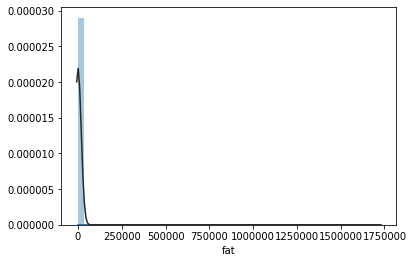

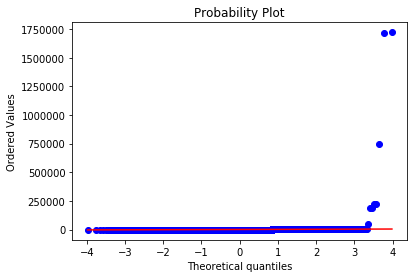

In [620]:
create_hist_prob_plot(data['fat'])

In [621]:
# skewness and kurtosis
print("Skewness: %f" % data['fat'].skew())
print("Kurtosis: %f" % data['fat'].kurt())

Skewness: 87.981638
Kurtosis: 8114.032632


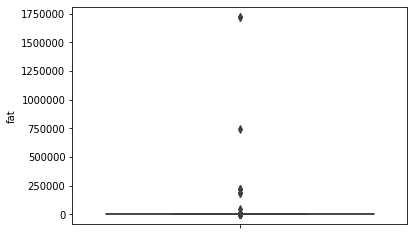

In [623]:
# detectando outliers
sns.boxplot(y=data['fat'])
plt.show()

In [590]:
# usando transformação log para ajustar os dados e diminuir os efeitos de outliers
data['fat'] = data['fat'].map(lambda i: np.log(i) if i > 0 else 0)
data['fat'].describe().round(decimals=2).drop('count')

mean     2.68
std      1.19
min      0.00
25%      2.30
50%      2.83
75%      3.33
max     14.36
Name: fat, dtype: float64

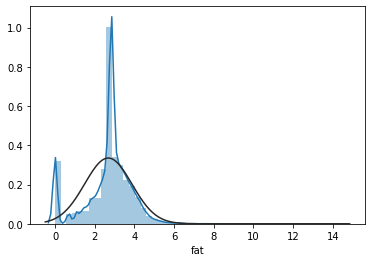

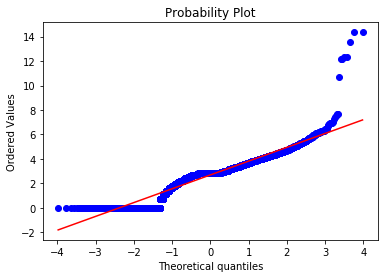

In [591]:
create_hist_prob_plot(data['fat'])

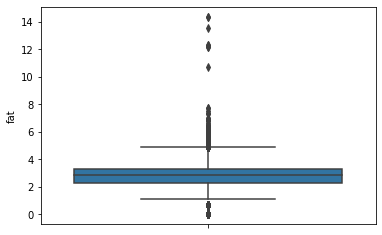

In [592]:
sns.boxplot(y=data['fat'])
plt.show()

In [600]:
data['fat'].describe()

count    20111.000000
mean         2.681783
std          1.190136
min          0.000000
25%          2.302585
50%          2.833213
75%          3.332205
max         14.359440
Name: fat, dtype: float64